In [1]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import Backgammon as B
#import agent as A
import flipped_agent as FA

#import pubeval_bg

In [2]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
        
    def choose_board(self, board):
        self.board = board
        self.done = False
        return np.copy(self.board)
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], self.board
        n_boards = np.shape(boards)[0]
        tesauro = np.zeros((n_boards, 198))
        for b in range(n_boards):
            tesauro[b,:] = features(boards[b], player)
        return moves, tesauro
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        tesauro_board = features(np.copy(self.board), player)
        return tesauro_board, reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

In [3]:
def reset_graph(seed=43):
    #tf.reset_default_graph()
    #tf.set_random_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
reset_graph()

In [4]:
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H1, H2, D_out = 198, 256, 128, 1

critic = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, D_out),
    torch.nn.Tanh(),
)

In [12]:
def get_action_and_value(actor, boards):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    with torch.no_grad():
        action = int(torch.multinomial(possible_actions_probs.view(1,-1), 1))
    action_value = possible_actions_probs[action]
    return action, action_value

def get_action_value(actor, boards, action):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    action_value = possible_actions_probs[action]
    return action_value

def get_action(actor, boards):
    with torch.no_grad():
        boards = torch.from_numpy(boards).float()
        possible_actions_probs = actor(boards)
        action = torch.multinomial(possible_actions_probs.view(1,-1), 1)
    return int(action)

def get_state_value(nn_model, after_state):
    after_state = torch.from_numpy(after_state).float()
    value = nn_model(after_state)
    return value

def epsilon_greedy(critic, possible_boards, epsilon=1):
    possible_boards = torch.from_numpy(possible_boards).float()
    values = critic(possible_boards)
    if np.random.random()<epsilon:
        _ , index = values.max(0)
    else:
        index = np.random.randint(0, len(possible_boards))
    return int(index)


In [6]:
"""
Use: f = features(board)
Input: board is is a 29-vector
Output: f is a 198-vector of features that follows Tesauro's procedure.
        See p. 423 in Sutton & Barto
"""
def features(board, player):
    f = np.zeros(198)
    
    # define features for points on board
    p = 0
    for i in range(1,25):
        point = board[i]
        #print('point:', point)
        #print('p: ', p)
        if (point != 0):
            #print('Not 0')
            if(point > 0):
                if (point == 1):
                    f[p] = 1
                elif (point == 2):
                    f[p+1] = 1
                elif (point == 3):
                    f[p+2] = 1
                else:
                    f[p+3] = (point-3)/2
            else:
                if (point == -1):
                    f[p+4] == 1
                elif (point == -2):
                    f[p+5] = 1
                elif (point == -3):
                    f[p+6] = 1
                else:
                    f[p+7] = (-point-3)/2
        p += 8
    
    f[192] = board[25]/2
    f[193] = board[26]/2
    f[194] = board[27]/15
    f[195] = board[28]/15
    f[196] = int(player == 1)
    f[197] = int(player == -1)
    return f

In [10]:
import time
rew_plt = []

def playAgainstRandom(num_games = 100, clear = True):
    global rew_plt
    rew = []
    for episode in range(num_games):
        env.reset()
        done = False

        while not done:
            dice = B.roll_dice()
            for i in range(1 + int(dice[0] == dice[1])):
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                if len(possible_moves) == 0:
                    break
                action = epsilon_greedy(critic, possible_boards)
                after_state, reward, done = env.step(possible_moves[action], player = 1)
                if done:
                    break

            if not done:
                dice = B.roll_dice()
                for i in range(1 + int(dice[0] == dice[1])):
                    next_state, reward, done = env.make_move(dice)
                    if done:
                        break


        rew.append(reward)

    if clear:
        clear_output(True)
    rew_plt.append(np.mean(np.equal(rew,1)))
    rew = []
    plt.plot(rew_plt)
    plt.axhline(0.5, color="gray")
    plt.show()
    print("Win rate:", rew_plt[-1])

EPISODE:  50 Steps: 47
EPISODE:  100 Steps: 39
EPISODE:  150 Steps: 31
EPISODE:  200 Steps: 46
EPISODE:  250 Steps: 23
EPISODE:  300 Steps: 32
EPISODE:  350 Steps: 22
EPISODE:  400 Steps: 23


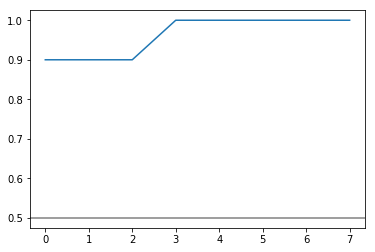

Win rate: 1.0
Time per 400: 68.79019951820374
EPISODE:  400
EPISODE:  450 Steps: 23
EPISODE:  500 Steps: 20
SAVE
EPISODE:  550 Steps: 27
EPISODE:  600 Steps: 29
EPISODE:  650 Steps: 24
EPISODE:  700 Steps: 44
EPISODE:  750 Steps: 32
EPISODE:  800 Steps: 26


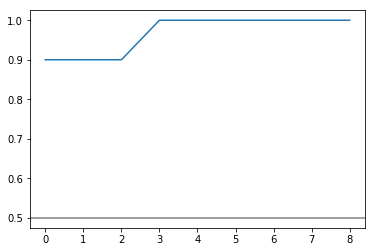

Win rate: 1.0
Time per 400: 57.7493679523468
EPISODE:  800
EPISODE:  850 Steps: 34
EPISODE:  900 Steps: 39
EPISODE:  950 Steps: 46
EPISODE:  1000 Steps: 23
SAVE
EPISODE:  1050 Steps: 24
EPISODE:  1100 Steps: 27
EPISODE:  1150 Steps: 41
EPISODE:  1200 Steps: 25


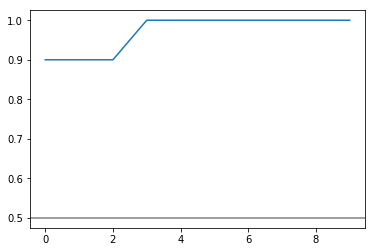

Win rate: 1.0
Time per 400: 56.64014482498169
EPISODE:  1200
EPISODE:  1250 Steps: 27
EPISODE:  1300 Steps: 33
EPISODE:  1350 Steps: 24
EPISODE:  1400 Steps: 32
EPISODE:  1450 Steps: 29
EPISODE:  1500 Steps: 32
SAVE
EPISODE:  1550 Steps: 32
EPISODE:  1600 Steps: 23


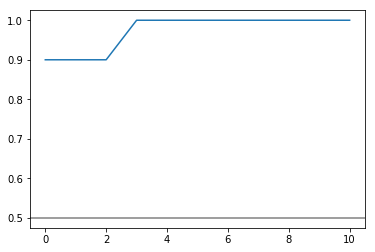

Win rate: 1.0
Time per 400: 51.98015809059143
EPISODE:  1600
EPISODE:  1650 Steps: 24
EPISODE:  1700 Steps: 32
EPISODE:  1750 Steps: 45
EPISODE:  1800 Steps: 23
EPISODE:  1850 Steps: 25
EPISODE:  1900 Steps: 27
EPISODE:  1950 Steps: 25
EPISODE:  2000 Steps: 23


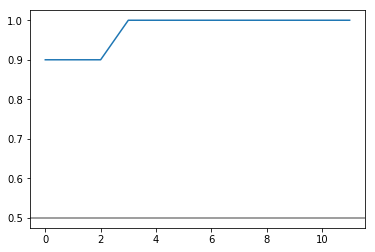

Win rate: 1.0
Time per 400: 56.58013343811035
EPISODE:  2000
SAVE
EPISODE:  2050 Steps: 21
EPISODE:  2100 Steps: 27
EPISODE:  2150 Steps: 34
EPISODE:  2200 Steps: 40
EPISODE:  2250 Steps: 31
EPISODE:  2300 Steps: 31
EPISODE:  2350 Steps: 33
EPISODE:  2400 Steps: 42


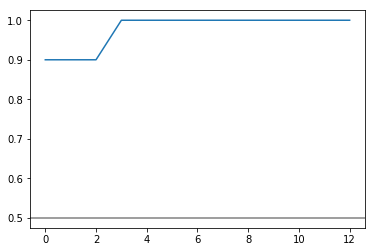

Win rate: 1.0
Time per 400: 59.146284103393555
EPISODE:  2400
EPISODE:  2450 Steps: 26
EPISODE:  2500 Steps: 22
SAVE
EPISODE:  2550 Steps: 36
EPISODE:  2600 Steps: 31
EPISODE:  2650 Steps: 30
EPISODE:  2700 Steps: 29
EPISODE:  2750 Steps: 40
EPISODE:  2800 Steps: 33


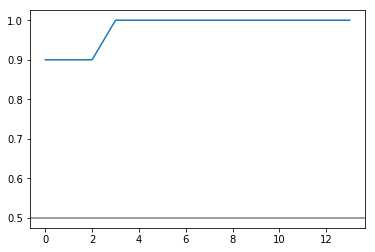

Win rate: 1.0
Time per 400: 59.94450283050537
EPISODE:  2800
EPISODE:  2850 Steps: 29
EPISODE:  2900 Steps: 22
EPISODE:  2950 Steps: 41
EPISODE:  3000 Steps: 25
SAVE
EPISODE:  3050 Steps: 27
EPISODE:  3100 Steps: 35
EPISODE:  3150 Steps: 25
EPISODE:  3200 Steps: 37


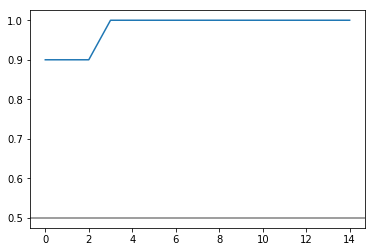

Win rate: 1.0
Time per 400: 65.86333632469177
EPISODE:  3200
EPISODE:  3250 Steps: 27
EPISODE:  3300 Steps: 28
EPISODE:  3350 Steps: 35
EPISODE:  3400 Steps: 38
EPISODE:  3450 Steps: 31
EPISODE:  3500 Steps: 32
SAVE
EPISODE:  3550 Steps: 32
EPISODE:  3600 Steps: 24


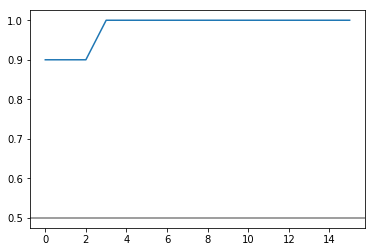

Win rate: 1.0
Time per 400: 56.72614026069641
EPISODE:  3600
EPISODE:  3650 Steps: 36
EPISODE:  3700 Steps: 30
EPISODE:  3750 Steps: 28
EPISODE:  3800 Steps: 37
EPISODE:  3850 Steps: 34
EPISODE:  3900 Steps: 22
EPISODE:  3950 Steps: 45
EPISODE:  4000 Steps: 34


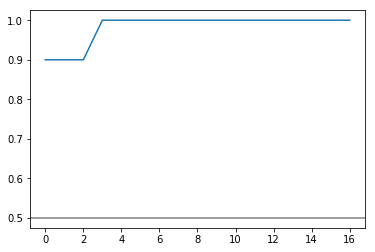

Win rate: 1.0
Time per 400: 56.68951416015625
EPISODE:  4000
SAVE
EPISODE:  4050 Steps: 48
EPISODE:  4100 Steps: 30
EPISODE:  4150 Steps: 41
EPISODE:  4200 Steps: 21
EPISODE:  4250 Steps: 37
EPISODE:  4300 Steps: 24
EPISODE:  4350 Steps: 32
EPISODE:  4400 Steps: 23


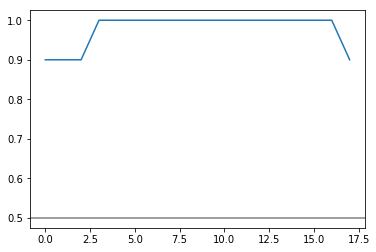

Win rate: 0.9
Time per 400: 71.04388046264648
EPISODE:  4400
EPISODE:  4450 Steps: 28
EPISODE:  4500 Steps: 21
SAVE
EPISODE:  4550 Steps: 34
EPISODE:  4600 Steps: 25
EPISODE:  4650 Steps: 36
EPISODE:  4700 Steps: 22
EPISODE:  4750 Steps: 30
EPISODE:  4800 Steps: 35


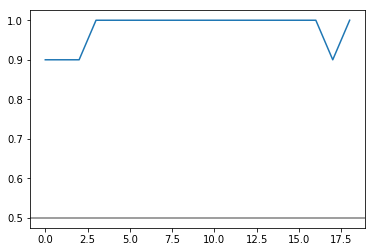

Win rate: 1.0
Time per 400: 71.5651638507843
EPISODE:  4800
EPISODE:  4850 Steps: 34
EPISODE:  4900 Steps: 28
EPISODE:  4950 Steps: 27
EPISODE:  5000 Steps: 28
SAVE
EPISODE:  5050 Steps: 32
EPISODE:  5100 Steps: 26
EPISODE:  5150 Steps: 22
EPISODE:  5200 Steps: 58


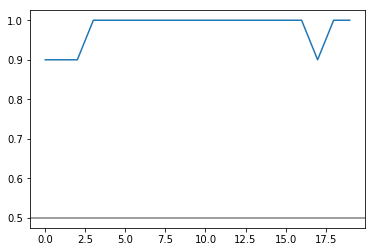

Win rate: 1.0
Time per 400: 73.3356237411499
EPISODE:  5200
EPISODE:  5250 Steps: 57
EPISODE:  5300 Steps: 31
EPISODE:  5350 Steps: 30
EPISODE:  5400 Steps: 50
EPISODE:  5450 Steps: 50
EPISODE:  5500 Steps: 57
SAVE
EPISODE:  5550 Steps: 29
EPISODE:  5600 Steps: 32


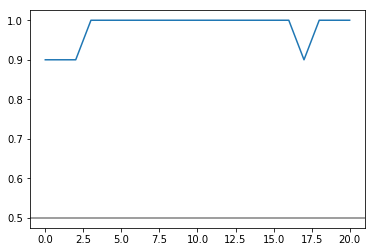

Win rate: 1.0
Time per 400: 70.59600138664246
EPISODE:  5600
EPISODE:  5650 Steps: 53
EPISODE:  5700 Steps: 71
EPISODE:  5750 Steps: 33
EPISODE:  5800 Steps: 33
EPISODE:  5850 Steps: 26
EPISODE:  5900 Steps: 29
EPISODE:  5950 Steps: 56
EPISODE:  6000 Steps: 36


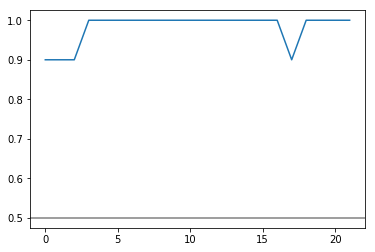

Win rate: 1.0
Time per 400: 79.76871705055237
EPISODE:  6000
SAVE
EPISODE:  6050 Steps: 57
EPISODE:  6100 Steps: 37
EPISODE:  6150 Steps: 40
EPISODE:  6200 Steps: 28
EPISODE:  6250 Steps: 27
EPISODE:  6300 Steps: 28
EPISODE:  6350 Steps: 83


In [ ]:
gamma = 1
#actor_alpha = 0.01
critic_alpha = 0.001
#actor_lambda = 0.7
critic_lambda = 0.7
forever = 10000

plt_iter = 400

env = backgammon()
tic = time.time()
step = 1

for episode in range(1,forever+1):
    if (episode%50==0):
        print("EPISODE: ", episode, "Steps:", step)

    env.reset()
    done = False
    step = 1
    
    I = 1
    #actor_Z = [ [0 for layer in actor.parameters()] for player in range(2) ]
    critic_Z = [ [0 for layer in critic.parameters()] for player in range(2) ]
    value = [[0,0],[0,0]] #value[player][0(old),1(new)]
        
    player = 0
    while not done:
        dice = B.roll_dice()
        for i in range(1 + int(dice[0] == dice[1])):
            possible_moves, possible_boards = env.legal_moves(dice, 1)
            if len(possible_moves) == 0:
                break
            action = epsilon_greedy(critic, possible_boards)
            after_state, reward, done = env.step(possible_moves[action], player = 1)
            if done:
                break
                
        if not done:
            value[player][0] = float(value[player][1]) # old_value
            value[player][1] = get_state_value(critic, after_state)
            critic.zero_grad()
            value[player][1].backward()
            with torch.no_grad():
                for i, param in enumerate(critic.parameters()):
                    critic_Z[player][i] = critic_lambda * critic_Z[player][i] + param.grad
            if (step>2):
                with torch.no_grad():
                    reward = 0 # Reward er 0
                    delta = reward + gamma*value[player][1] - value[player][0]

                    for i, param in enumerate(critic.parameters()):
                        param += critic_alpha * delta * critic_Z[player][i]
            
            if player==0:
                #I *= gamma
                step += 1
            player = 1 - player
            env.swap_player()
            
    value[player][0] = float(value[player][1])
    value[player][1] = 0
    
    value[1 - player][0] = float(value[1 - player][1])
    value[1 - player][1] = 0
    
    with torch.no_grad():
        delta1 = reward + gamma*value[player][1] - value[player][0]
        delta2 = -reward + gamma*value[1 - player][1] - value[1 - player][0]
        
        for i, param in enumerate(critic.parameters()):
            param += critic_alpha * delta1 * critic_Z[player][i]
            param += critic_alpha * delta2 * critic_Z[1 - player][i]
            
    if episode%plt_iter == 0:
        toc = time.time()
        playAgainstRandom(num_games = 10, clear = False)
        print("Time per {}: {}".format(plt_iter, toc-tic))
        print("EPISODE: ", episode)
        tic = time.time()
        
    if episode%500 == 0:
        print("SAVE")
        torch.save(critic.state_dict(), "critic_nn_greedy.pth")
